# Battery State of Health (SoH) Estimation
Week 3 Implementation

This notebook contains:
1. Dataset creation (provided structure)
2. Transformer-based SoH estimation model
3. Physics-constrained loss
4. Evaluation plots

In [2]:

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import kagglehub
path = kagglehub.dataset_download("patrickfleith/nasa-battery-dataset")

V_CUTOFF = 2.7
CAPACITY_MIN_AH = 1
BINS = 20
M = 200  # physics resolution
NOMINAL_AH = 2.0

metadata = pd.read_csv(os.path.join(path, "cleaned_dataset", "metadata.csv"))
metadata["battery_id"] = metadata["battery_id"].astype(str)

excluded_batteries = ["B0049", "B0050", "B0051", "B0052"]

discharge_metadata = metadata[
    (metadata["type"] == "discharge") &
    (~metadata["battery_id"].isin(excluded_batteries))
].copy()

discharge_metadata["cycle_number"] = discharge_metadata.groupby("battery_id").cumcount()

main_rows = []
phys_rows = []


100%|██████████| 228M/228M [00:01<00:00, 180MB/s]

Extracting files...


In [14]:

for _, row in tqdm(discharge_metadata.iterrows(), total=len(discharge_metadata)):
    file_path = os.path.join(path, "cleaned_dataset", "data", row["filename"])
    df = pd.read_csv(file_path).copy()

    df = df.sort_values("Time").drop_duplicates(subset=["Time"], keep="first")
    if len(df) < 5:
        continue

    cutoff_idx = df[df["Voltage_measured"] < V_CUTOFF].index.min()
    if not pd.isna(cutoff_idx):
        df = df.loc[:cutoff_idx].copy()

    if len(df) < 5:
        continue

    df["dt_hr_raw"] = df["Time"].diff().fillna(0) / 3600.0
    df["dQ"] = df["Current_measured"] * df["dt_hr_raw"]
    capacity = abs(df["dQ"].sum())

    if capacity <= CAPACITY_MIN_AH or capacity >= NOMINAL_AH:
        continue

    df["CumQ"] = df["dQ"].cumsum()
    df["SoC"] = 100.0 * (1.0 + df["CumQ"] / capacity)
    soh_value = 100.0 * capacity / NOMINAL_AH

    t = df["Time"].to_numpy()
    t0, t1 = float(t[0]), float(t[-1])
    if t1 <= t0:
        continue

    t_grid = np.linspace(t0, t1, M)
    dt_hr = np.diff(t_grid, prepend=t_grid[0]) / 3600.0

    def interp(col):
        return np.interp(t_grid, t, df[col].to_numpy())

    Vg = interp("Voltage_measured")
    Ig = interp("Current_measured")
    Tg = interp("Temperature_measured")
    SOCg = interp("SoC")

    rs = pd.DataFrame({
        "Time_s": t_grid - t0,
        "dt_hr": dt_hr,
        "Voltage_measured": Vg,
        "Current_measured": Ig,
        "Temperature_measured": Tg,
        "SoC": SOCg,
    })

    chunks = np.array_split(rs, BINS)
    if len(chunks) != BINS or any(c.empty for c in chunks):
        continue

    for b_idx, c in enumerate(chunks):
        main_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "bin_idx": b_idx,
            "Voltage_measured": c["Voltage_measured"].mean(),
            "Current_measured": c["Current_measured"].mean(),
            "Temperature_measured": c["Temperature_measured"].mean(),
            "SoC": c["SoC"].mean(),
            "Capacity_Ah": capacity,
            "SoH": soh_value
        })

main_df = pd.DataFrame(main_rows)
main_df.to_csv("battery_main_binned20.csv", index=False)

print("Saved dataset:", main_df.shape)


  0%|          | 0/2694 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.1

Saved dataset: (133280, 9)


In [34]:
class SOHTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        self.pos_embedding = nn.Parameter(torch.randn(1, 20, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.regressor = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = x + self.pos_embedding
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze(-1)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_df = pd.read_csv("battery_main_binned20.csv")
# Drop duplicates based on battery_id, cycle_number, and bin_idx
main_df.drop_duplicates(subset=['battery_id', 'cycle_number', 'bin_idx'], inplace=True)

feature_cols = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "SoC"
]

grouped = main_df.groupby(["battery_id", "cycle_number"])

X_list, y_list = [], []

for _, g in grouped:
    g = g.sort_values("bin_idx")
    if len(g) != 20:
        continue
    X_list.append(g[feature_cols].values)
    y_list.append(g["SoH"].values[0])

X = torch.tensor(np.array(X_list), dtype=torch.float32)
y = torch.tensor(np.array(y_list), dtype=torch.float32)


# Normalize Features

X_mean = X.mean(axis=(0,1), keepdims=True)
X_std = X.std(axis=(0,1), keepdims=True) + 1e-6

X = (X - X_mean) / X_std

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class BatteryDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = BatteryDataset(X_train, y_train)
test_dataset = BatteryDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # No need to shuffle test data

model = SOHTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(25):
    total_loss = 0
    for xb, yb in train_loader: # Use train_loader for training
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

Epoch 1 Loss: 272754.8462
Epoch 2 Loss: 91984.7101
Epoch 3 Loss: 8913.7927
Epoch 4 Loss: 3439.1163
Epoch 5 Loss: 2527.6569
Epoch 6 Loss: 2004.7628
Epoch 7 Loss: 1731.6958
Epoch 8 Loss: 1257.4829
Epoch 9 Loss: 1054.1961
Epoch 10 Loss: 1000.1735
Epoch 11 Loss: 889.5580
Epoch 12 Loss: 871.5948
Epoch 13 Loss: 925.3350
Epoch 14 Loss: 812.9729
Epoch 15 Loss: 913.4234
Epoch 16 Loss: 765.5201
Epoch 17 Loss: 759.6734
Epoch 18 Loss: 742.1958
Epoch 19 Loss: 717.3778
Epoch 20 Loss: 730.6955
Epoch 21 Loss: 660.1150
Epoch 22 Loss: 661.2992
Epoch 23 Loss: 677.4519
Epoch 24 Loss: 642.0564
Epoch 25 Loss: 739.0431


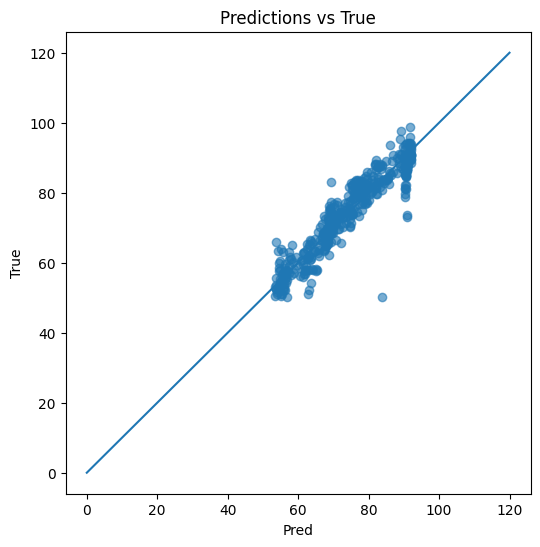

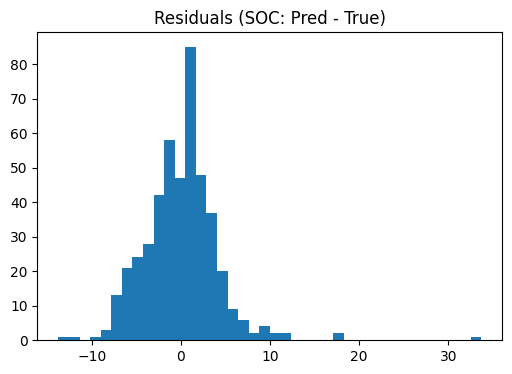

In [36]:

# Evaluation

model.eval()
preds = []
trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

residuals = preds - trues



# Plot: Predictions vs True

plt.figure(figsize=(6,6))
plt.scatter(preds, trues, alpha=0.6)
plt.plot([0,120],[0,120])
plt.xlabel("Pred")
plt.ylabel("True")
plt.title("Predictions vs True")
plt.show()



# Plot Residuals

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.title("Residuals (SOC: Pred - True)")
plt.show()

In [37]:
class SoHTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=64, nhead=4, num_layers=2):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                batch_first=True
            ) for _ in range(num_layers)
        ])

        self.regressor = nn.Linear(d_model, 1)

        self.attn_maps = []

    def forward(self, x, return_attn=False):
        self.attn_maps = []

        x = self.embedding(x)

        for layer in self.layers:
            # Capture attention
            attn_out, attn = layer.self_attn(
                x, x, x,
                need_weights=True,
                average_attn_weights=False
            )
            self.attn_maps.append(attn)

            # Run full encoder layer (correct!)
            x = layer(x)

        x = x.mean(dim=1)
        out = self.regressor(x)

        if return_attn:
            return out.squeeze(), self.attn_maps

        return out.squeeze()
model = SoHTransformer().to(device)

In [38]:
import inspect
print(inspect.signature(model.forward))

(x, return_attn=False)


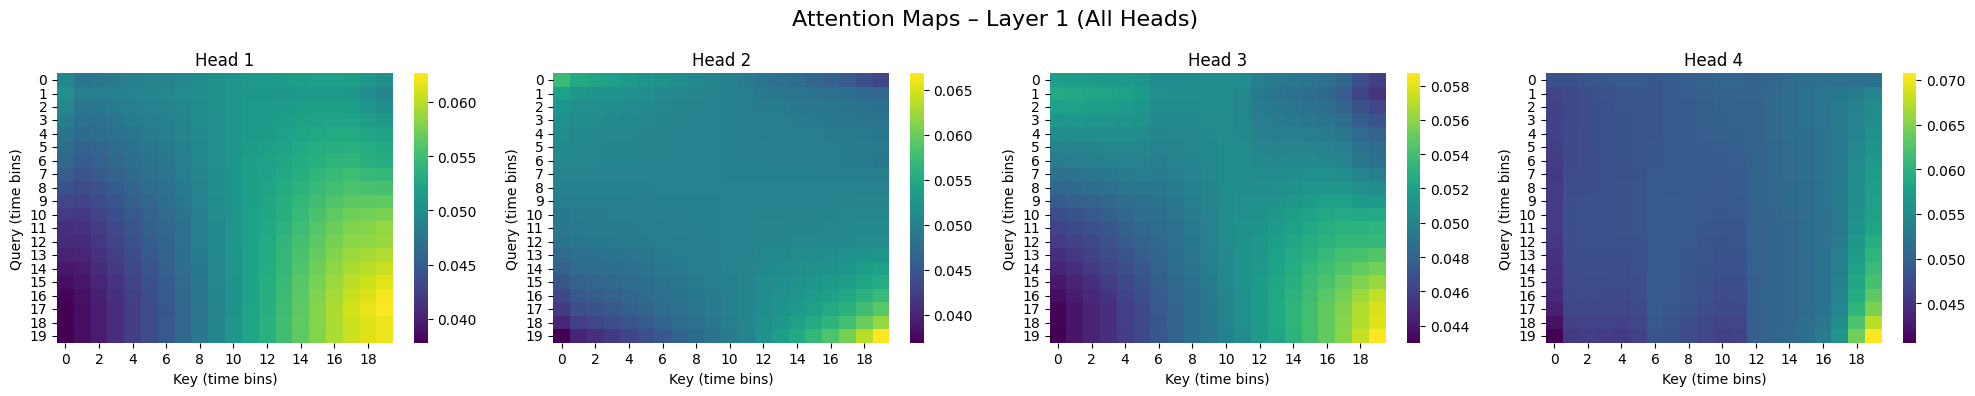

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

xb, yb = next(iter(test_loader))
xb = xb.to(device)

with torch.no_grad():
    _, attns = model(xb, return_attn=True)

# Choose layer and sample
layer_idx = 0     # Layer 1
sample_idx = 0    # First sample in batch

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for h in range(4):
    A = attns[layer_idx][sample_idx, h].detach().cpu().numpy()
    sns.heatmap(
        A,
        ax=axes[h],
        cmap="viridis",
        cbar=True
    )
    axes[h].set_title(f"Head {h+1}")
    axes[h].set_xlabel("Key (time bins)")
    axes[h].set_ylabel("Query (time bins)")

plt.suptitle("Attention Maps – Layer 1 (All Heads)", fontsize=16)
plt.tight_layout()
plt.show()